# US Gap Analysis Project - WV Breeding Bird Atlas Data Comparison

*Nathan Tarr and Jessie Jordan*

## Cover type associations in West Virginia Summarized Across All Species

We investigated the agreement between WV Breeding Bird Atlas (2011-2015) and USGS Gap Analysis Project data

In [1]:
import pandas as pd
import numpy as np
import repo_functions as fun
pd.set_option('display.width', 2000)
pd.set_option('display.max_colwidth', 400)
pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 15)

In [2]:
# Call species lists and generate empty dataframes-----------------------------
specieslist = (pd.read_csv(fun.dataDir + "/SpeciesLists/WV_GAP_Atlas3.csv", 
                           index_col ='common_name', header=0))
mastdf = pd.DataFrame(index=[ "Unusable", "Supported validation", 
                                        "Supported addition", 
                                        "Total detections"], 
                             columns=["Species", "detections"])
masteval = pd.DataFrame(index=[ "Unvalidated", "Validated", 
                              "Additions"], columns=["Species", 
                                            "GAP_types"])
typedf = pd.DataFrame(index=['GAP_name', 'evaluation'], columns=['GAP_code', 'GAP_associated', 
                                         'cross_confidence', 'cross_matches', 'detections', 
                                         'wv_code_fine', 'wv_name_fine', 'link_strength', 'GAP_name', 
                                         'support', 'evaluation'])

allunmatch = []

# Load land cover crosswalk - slow loading for some reason
cross = pd.read_csv(fun.dataDir + "LandCover/land_cover_crosswalk.csv", 
                    header=0, dtype={'GAP_code': str}) 


In [3]:
for species in specieslist.index[0:] :
    try:
        # Perform crosswalk of detections from WV -> USGAP
        master, GAP_linked, unmatched, gap_types, wv_types = fun.cross_to_GAP(species, 
                                                    cross, print_tables=False)
        
        master_valid = master[master['evaluation'] == 'valid']
        master_add = master[master['evaluation'] == 'add_association']
        usable_df = pd.DataFrame(index=[ "Unusable", "Supported validation", 
                                        "Supported addition", 
                                        "Total detections"], 
                             columns=["detections"])
        usable_df.loc['Supported validation', 
                      'detections'] = int(master_valid[['detections']].sum())
        usable_df.loc['Supported addition', 
                      'detections'] = int(master_add[['detections']].sum())
        usable_df.loc['Unusable', 
                      'detections'] = int(wv_types['detections'].sum() - 
                                          master_valid[['detections']].sum() - 
                                          master_add[['detections']].sum())
        usable_df.loc['Total detections', 
                      'detections'] = wv_types['detections'].sum()
        usable_df.insert(0, "Species", species, True)
        usable_df = usable_df.fillna(0)
        mastdf = pd.concat([usable_df, mastdf])
        typedf = pd.concat([master, typedf])
        
        # Aggregate results for proportion of GAP systems validated------------
        eval_df = pd.DataFrame(index=[ "Unvalidated", "Validated", 
                                      "Additions"], columns=["GAP_types"])
        eval_df.loc['Unvalidated', "GAP_types"] = len(gap_types) - len(master_valid)
        eval_df.loc['Validated', "GAP_types"] = len(master_valid)
        eval_df.loc['Additions', "GAP_types"] = len(master_add)
        eval_df.insert(0, "Species", species, True)
        eval_df = eval_df.fillna(0)
        masteval = pd.concat([eval_df, masteval])
        
        #Generate a full list of unmatched habitat types across all species
        allunmatch.append(unmatched)
    except Exception as e: 
            print(str("Concatonate failed for ") + species)
print("Data compiled succesfully")

Concatonate failed for Bewick's Wren
Concatonate failed for Hooded Merganser
Concatonate failed for King Rail
Concatonate failed for Prothonotary Warbler
Concatonate failed for Ruby-crowned Kinglet
Concatonate failed for Rusty Blackbird
Concatonate failed for Eurasian Collared-dove
Concatonate failed for Northern Goshawk
Concatonate failed for Northern Saw-whet Owl
Concatonate failed for Peregrine Falcon
Concatonate failed for Pine Grosbeak
Concatonate failed for Redhead
Concatonate failed for Ring-necked Duck
Concatonate failed for Bufflehead
Concatonate failed for Common Goldeneye
Concatonate failed for Hoary Redpoll
Concatonate failed for Lark Sparrow
Concatonate failed for Red Crossbill
Concatonate failed for Rough-legged Hawk
Concatonate failed for Ring-necked Pheasant
Concatonate failed for Short-eared Owl
Concatonate failed for Snowy Owl
Concatonate failed for Sora
Concatonate failed for Black-crowned Night-heron
Concatonate failed for Eurasian Wigeon
Concatonate failed for Gadw

In [4]:
#Convert list of dictionaraies to an organized dataframe
df = pd.DataFrame(allunmatch)

#Find the sum and count of occurances records for each mismatched code
undf = pd.DataFrame(index = df.T.index, columns = ['Unmatched Observations', 'Number of spp with Record'])
undf['Unmatched Observations'] = df.T.sum(axis=1)
undf['Number of spp with Record'] = df.T.count(axis=1)
print(undf[['Unmatched Observations', 'Number of spp with Record']])
unobvs = undf['Unmatched Observations'].T.sum(axis=0)

#Sum all unmatched occurances for each species and find the average
sumspp = df.sum(axis=1)
avgun = sumspp.mean(axis=0)

print("Average number of unusable records per species due to incorrect or other data entry: " + str(avgun))
print("Total Unmatched observations due to incorrect or other code entry: " + str(unobvs)) 


     Unmatched Observations  Number of spp with Record
32                    745.0                         71
,                       1.0                          1
32b                     2.0                          2
68                      4.0                          2
32a                     4.0                          3
e                       2.0                          1
u                       5.0                          3
39                      1.0                          1
j                       1.0                          1
176                     3.0                          1
f                       3.0                          2
Average number of unusable records per species due to incorrect or other data entry: 5.546762589928058
Total Unmatched observations due to incorrect or other code entry: 771.0


In [5]:
#create table with count of validated systems
typedf['evaluation'].fillna(value = 'No match', inplace = True)
typedf.set_index(['GAP_name','evaluation'], inplace=True)
typedf.insert(5, 'Times Validated', '1', True)
typedf= typedf.astype({'Times Validated': 'int32'})
valdf = typedf.groupby(['GAP_name','evaluation'])["Times Validated"].count()
print(valdf)

GAP_name                                                             evaluation     
Allegheny-Cumberland Dry Oak Forest and Woodland - Hardwood          No match            86
Allegheny-Cumberland Dry Oak Forest and Woodland - Pine Modifier     No match            78
Appalachian Hemlock-Hardwood Forest                                  No match            80
Appalachian Shale Barrens                                            No match            33
Central Appalachian Alkaline Glade and Woodland                      No match            49
Central Appalachian Oak and Pine Forest                              No match            80
Central Appalachian Pine-Oak Rocky Woodland                          No match            35
                                                                     add_association      8
                                                                     valid               35
Central Appalachian Riparian - Forest Modifier                       No match          

                                Species  detections
Unusable              Willow Flycatcher        40.0
Supported validation  Willow Flycatcher         3.0
Supported addition    Willow Flycatcher         5.0
Total detections      Willow Flycatcher        48.0
Unusable               White-eyed Vireo       126.0
...                                 ...         ...
Total detections          Blue Grosbeak        11.0
Unusable               American Kestrel        27.0
Supported validation   American Kestrel         0.0
Supported addition     American Kestrel         6.0
Total detections       American Kestrel        33.0

[556 rows x 2 columns]
                     Species-Habitat Detections                   
                                          Count     Average  Total
Supported addition                           46   22.215827   3088
Supported validation                         63   38.913669   5409
Total detections                            106  287.129496  39911
Unusable         

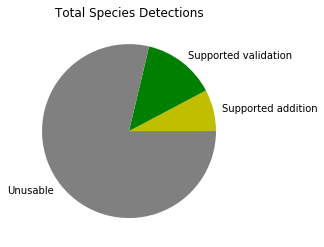

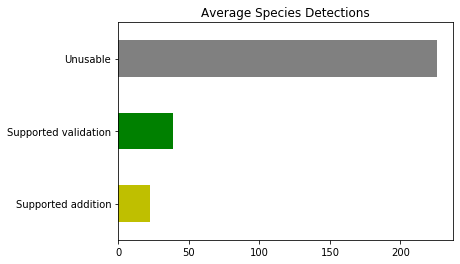

In [6]:
#Clean up master tables to create pivot tables
mastdf = mastdf.dropna()
masteval = masteval.dropna().astype({'GAP_types': 'int32'})
print(mastdf)
#Create pivot table summarizing the validity of WVBBA habitat detections
pivdf = mastdf.pivot_table(index = mastdf.index,
                           aggfunc = {'detections' : [ np.mean, sum, lambda x: len(x.unique())]},
                           fill_value = 0).sort_index()
pivdf.rename(columns={"detections" : "Species-Habitat Detections", 
                      "mean" : "Average", "sum" : "Total", "<lambda_0>" : "Count"}, inplace=True) 

#Display Table and plot pie chart of total detections
print(pivdf)
plt1 = pivdf.drop(['Total detections']).plot(y=('Species-Habitat Detections',        'Total'), 
                                             kind='pie',
                                             legend=False, 
                                             title = "Total Species Detections",
                                             colors=['y', 'g', 'gray'])
plt1.set_ylabel("")
plt2 = pivdf.drop(['Total detections']).plot.barh(x= None, y=('Species-Habitat Detections',        'Average'), 
                                                  color=['y', 'g', 'gray'], legend=False, title = "Average Species Detections")   

            GAP Systems Validated by WVBBA                 
                                     Count    Average Total
Additions                                7   1.676259   233
Unvalidated                             47  18.345324  2550
Validated                                8   1.755396   244


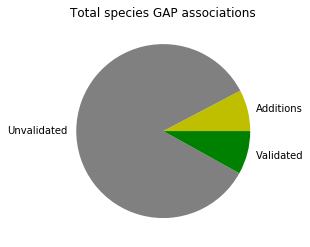

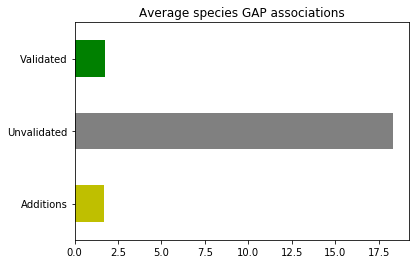

In [7]:
#Create pivot table summarizing the proportion of GAP systems validated 
piveval = masteval.pivot_table(index = masteval.index,
                           aggfunc = {'GAP_types' : [np.mean, sum, lambda x: len(x.unique())]},
                           fill_value = 0).sort_index()
piveval.rename(columns={"GAP_types" : "GAP Systems Validated by WVBBA", "mean" : "Average", 
                        "sum" : "Total", "<lambda_0>" : "Count"}, inplace=True)

#Display data table and plot tables of the sum of validated GAP associations and the average per species
print(piveval)
plt3 = piveval.plot(y=('GAP Systems Validated by WVBBA',        'Total'), 
                                             kind='pie',
                                             legend=False, 
                                             title = "Total species GAP associations",
                                             colors=['y', 'gray', 'g'])
plt3.set_ylabel("")
plt4 = piveval.plot.barh(x = None, y=('GAP Systems Validated by WVBBA',        'Average'), 
                         color=['y', 'gray', 'g'],
                         legend=False, title = "Average species GAP associations") 

In [8]:
print(typedf)

                                                                  GAP_code  GAP_associated  cross_confidence  cross_matches  detections  Times Validated wv_code_fine    wv_name_fine  link_strength support
GAP_name                                          evaluation                                                                                                                                                
Developed, High-intensity                         No match            1204             0.0               1.0            1.0         1.0                1          18b      Commerical            1.0    high
Pasture/Hay                                       add_association     1403             0.0               1.0            1.0         5.0                1          17a         Pasture            1.0    high
Open Water (Fresh)                                No match            2102             0.0               1.0            1.0         1.0                1          15c  Pond/reservoi